## OJT2 - Hebrew  Sentimental Classifier

In [1]:
import codecs
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sn
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
# Get Hebrew stop words - taken from https://github.com/gidim/HebrewStopWords

heb_stopwords = list(pd.read_csv('data\\heb_stopwords.txt').values.squeeze())

def remove_eng_sec(df):
    for i, l in enumerate(df):
        df.loc[i] = re.sub("[^\u0590-\u05FF]+", " ", l)
    return df
    
def remove_heb_stopwords(df, stopwords):
    for i, line in enumerate(df):
        line = ' '.join([word for word in line.split() if word not in stopwords])
        df.loc[i] = line
    return df

### Conversion of data to train & test

In [3]:
morph_train= pd.read_csv('data\\morph_train.tsv', delimiter='\t', quoting=3, names=['Sentence', 'y']) 
morph_test= pd.read_csv('data\\morph_test.tsv', delimiter='\t' ,quoting=3, names=['Sentence', 'y'])
#morph_train.columns = ['Sentence', 'y'] # For some reason it doesn't work, so had to find another way (such as names)
#morph_test.columns = ['Sentence', 'y']


# Change y values to labels
morph_train["y"].replace({0: "Pos", 1: "Neg", 2: "Nat"}, inplace=True)
morph_test["y"].replace({0: "Pos", 1: "Neg", 2: "Nat"}, inplace=True)

In [4]:
morph_train.head()

,Sentence,y
0,ממש כואב ..... אני בכה את היא עם ה משפחה ש לא ...,Pos
1,איש יקר של אנחנו,Pos
2,כל ה כבוד ו המון ב הצלחה,Pos
3,""" תל חי , רובי . ב כל ה עצב ה זה היית קרן אור ...",Pos
4,נקי כפיים ו בר לבב ב הצלחה ל אתה ו ל אנחנו .,Pos


In [5]:
morph_train.shape

(10244, 2)

### Data Cleaning

In [6]:
morph_train["Sentence"] = remove_heb_stopwords(morph_train["Sentence"], heb_stopwords)
morph_test["Sentence"] = remove_heb_stopwords(morph_test["Sentence"], heb_stopwords)

morph_train["Sentence"] = remove_eng_sec(morph_train["Sentence"])
morph_test["Sentence"]  =  remove_eng_sec(morph_test["Sentence"])

#morph_train["Sentence"] = remove_eng_words(morph_train["Sentence"])
#morph_test["Sentence"]  =  remove_eng_words(morph_test["Sentence"])



In [7]:
morph_train.head()

,Sentence,y
0,כואב בכה את משפחה תדעו צער,Pos
1,איש יקר,Pos
2,כבוד הצלחה,Pos
3,תל חי רובי עצב היית אור תקוה אכן נשיא,Pos
4,נקי כפיים לבב הצלחה,Pos


In [8]:
morph_train.shape

(10244, 2)

In [9]:
nan_value = float("NaN")
morph_train.replace("", nan_value, inplace=True)
morph_test.replace("", nan_value, inplace=True)

morph_train.dropna(subset = ["Sentence"], inplace=True)
morph_test.dropna(subset = ["Sentence"], inplace=True)

In [10]:
morph_train.shape

(10201, 2)

### TF - IDF vectorizer (for train & test)

In [11]:
# For x morph train data
vector = TfidfVectorizer(use_idf=True, stop_words=heb_stopwords)
tfidf_vectorizer_morph_train=TfidfVectorizer(use_idf=True, max_df = 0.95) 


X_train = vector.fit_transform(morph_train['Sentence']).toarray()
X_test = vector.transform(morph_test['Sentence']).toarray()
y_train = morph_train['y']
y_test = morph_test['y']
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(10201, 16338) (10201,)
(2550, 16338) (2550,)


#### Logistic Regression Classifier

In [12]:
# For classifier
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression()

#### Confusion Matrix

In [13]:
y_pred_train = classifier.predict(X_train)
cm_train = confusion_matrix(y_train, y_pred_train)
print(cm_train)
accuracy_score(y_train, y_pred_train)

[[  64   74  156]
 [   0 2917  208]
 [   2  111 6669]]


0.9459856876776787

In [14]:
y_pred_test = classifier.predict(X_test)
cm_test = confusion_matrix(y_test, y_pred_test)
print(cm_test)
accuracy_score(y_test, y_pred_test)

[[   9   20   42]
 [   0  639  151]
 [   1   65 1623]]


0.8905882352941177

<AxesSubplot:>

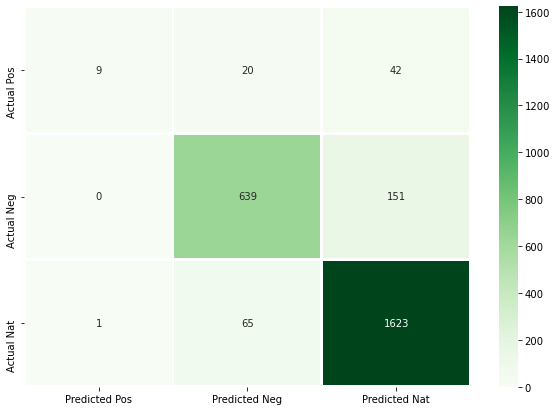

In [15]:
df_confusion = pd.DataFrame(cm_test,index = ['Actual Pos', 'Actual Neg', 'Actual Nat'], columns = ['Predicted Pos', 'Predicted Neg', 'Predicted Nat'])
plt.figure(figsize = (10,7))
sn.heatmap(df_confusion, annot=True, cmap="Greens", linewidths=2, fmt='g')

#### We can see that the lowest sentiment prediction rate was Pos

In [16]:
feature_names = vector.get_feature_names()
feature_names = [get_display(word) for word in feature_names]
importances = classifier.coef_
sorted_importances = []
for i in range(3):
    zipped_lists = zip(importances[i], feature_names)
    sorted_importances.append(dict(sorted(zipped_lists)[::-1]))

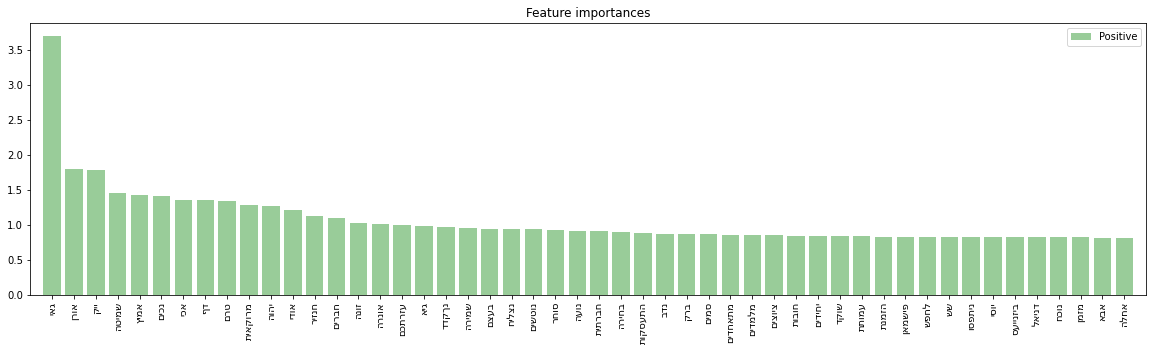

In [17]:
plt.figure(figsize = (20,5))
plt.title("Feature importances")
plt.bar(range(50), list(sorted_importances[0].keys())[:50], color="g", align="center", label='Positive', alpha=0.4)
plt.xticks(range(50), list(sorted_importances[0].values())[:50], rotation=90)
plt.xlim([-1, 50])
plt.legend()
plt.show()

#### Seems like many English words appear, so we might need to remove them.

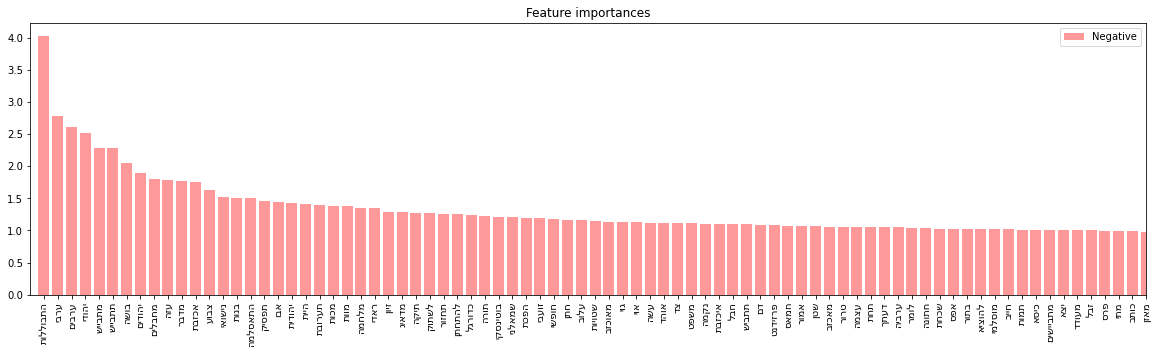

In [18]:
plt.figure(figsize = (20,5))
plt.title("Feature importances")
plt.bar(range(100), list(sorted_importances[1].keys())[:100], color="r", align="center", label='Negative', alpha=0.4)
plt.xticks(range(100), list(sorted_importances[1].values())[:100], rotation=90)
plt.xlim([-1, 80])
plt.legend()
plt.show()

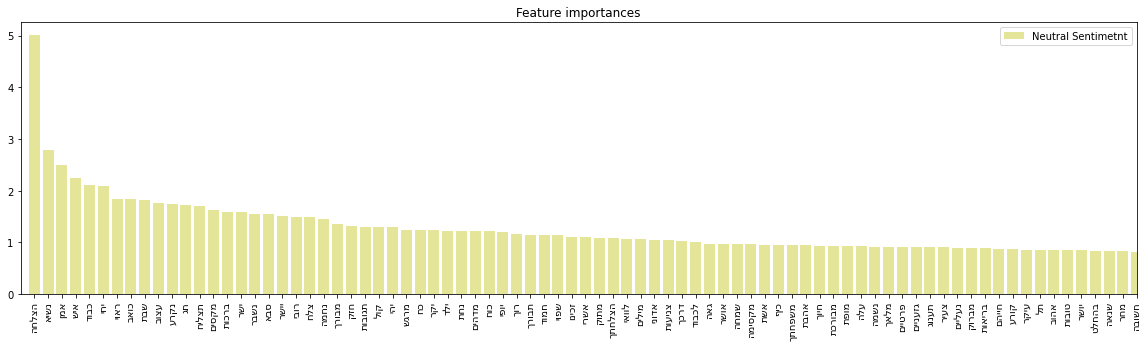

In [19]:
plt.figure(figsize = (20,5))
plt.title("Feature importances")
plt.bar(range(100), list(sorted_importances[2].keys())[:100], color="y", align="center", label='Neutral Sentimetnt', alpha=0.4)
plt.xticks(range(100), list(sorted_importances[2].values())[:100], rotation=90)
plt.xlim([-1, 80])
plt.legend()
plt.show()

In [20]:
df_freq = pd.concat([morph_train, morph_test], ignore_index = True)

In [21]:
cv_pos = CountVectorizer(analyzer='word')

# Vectorizing pos reviews set
vect = CountVectorizer(stop_words = heb_stopwords, analyzer='word')
vect_pos = vect.fit_transform(df_freq[df_freq.y.isin(['Pos'])].Sentence)

# Visualising the high frequency words for positive set
df_freq_pos = pd.DataFrame(vect_pos.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq_pos.nlargest(10, 'frequency')

,frequency
נשיא,3998
את,3178
כבוד,1862
הצלחה,1749
רובי,944
מדינת,713
מדינה,711
ריבלין,624
יקר,550
איש,541


In [22]:
cv_neg = CountVectorizer(analyzer='word')

# Vectorizing neg reviews set
vect = CountVectorizer(stop_words = heb_stopwords, analyzer='word')
vect_neg = vect.fit_transform(df_freq[df_freq.y.isin(['Neg'])].Sentence)

# Visualising the high frequency words for positive set
df_freq_neg = pd.DataFrame(vect_neg.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq_neg.nlargest(10, 'frequency')

,frequency
את,4406
נשיא,2026
מדינה,782
כבוד,690
יהודי,686
התבוללות,634
יהודים,533
מדינת,474
ערבים,449
ערבי,382


In [23]:
cv_nat = CountVectorizer(analyzer='word')

# Vectorizing nat reviews set
vect = CountVectorizer(stop_words = heb_stopwords, analyzer='word')
vect_nat = vect.fit_transform(df_freq[df_freq.y.isin(['Nat'])].Sentence)

# Visualising the high frequency words for positive set
df_freq_nat = pd.DataFrame(vect_nat.sum(axis=0), columns=list(vect.get_feature_names()), index = ['frequency']).T
df_freq_nat.nlargest(10, 'frequency')

,frequency
את,371
נשיא,43
כש,35
גאי,28
נהיגה,28
ייק,25
כבוד,24
נכים,24
צפון,24
דף,23


In [27]:
neg = df_freq.y == "Neg"


In [45]:
print(df_freq[neg]['Sentence'])

9        אדוני נשיא סליחה בוטות תפסיק לזיין את התבטאת מ...
11                                  חשבתי הגיע נשיא נורמלי
12       נשיא מדינה מנותק חכם דיבורים אמת לטפל פצעי מכו...
14        רובי ריבלין יקר איש משפחה היית מגיב מתחתנת ער...
18                                         תפקיד שכחת באת 
                               ...                        
12738     תגיד גיא יהודי עוקר את תורה דת הפעם אחרונה נכ...
12739    לצטט את זבוטינסקי כבוד נשיא תתמקד תורה קדושה ז...
12740                רובי יקר נשיא מדינת ביתך היית עשה את 
12744    אדוני נשיא תנסה להקיא את חברי הכנסת ערביים בוג...
12748    קרה נהיית נשיא נהיית פרס תתעסק הסתות ערבים תבו...
Name: Sentence, Length: 3915, dtype: object


In [48]:
# Start with one review:
text = df_freq[neg]
# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

TypeError: expected string or bytes-like object